<a href="https://colab.research.google.com/github/seunghy1468/Sparta_Coding_Machine_Learning/blob/main/4%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5_01_Sign_Language_MNIST_(CNN)%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝에서 실행 속도를 더 빠르게 하는 방법

지금까지는 CPU를 사용했는데 GPU를 사용하면 딥러닝의 연산속도를 대폭 향상시킬 수 있습니다!

[런타임] - [런타임 유형 변경] - 하드웨어 가속기 GPU 선택 저장

# 데이터셋 다운로드

영어 알파벳 수화 데이터셋

https://www.kaggle.com/datamunge/sign-language-mnist

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'kairess' # username
os.environ['KAGGLE_KEY'] = '7d0443b2dfffc57c94271fd797511896' # key

In [ ]:
!kaggle datasets download -d datamunge/sign-language-mnist

 78% 49.0M/62.6M [00:00<00:00, 34.5MB/s]
100% 62.6M/62.6M [00:01<00:00, 64.6MB/s]


In [ ]:
!unzip sign-language-mnist.zip

Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


# 패키지 로드

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 데이터셋 로드

In [ ]:
train_df = pd.read_csv('sign_mnist_train.csv')

train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [ ]:
test_df = pd.read_csv('sign_mnist_test.csv')

test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


# 라벨 분포
- 9=J or 25=Z 는 동작이 들어가므로 제외
- 총 24개의 라벨

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


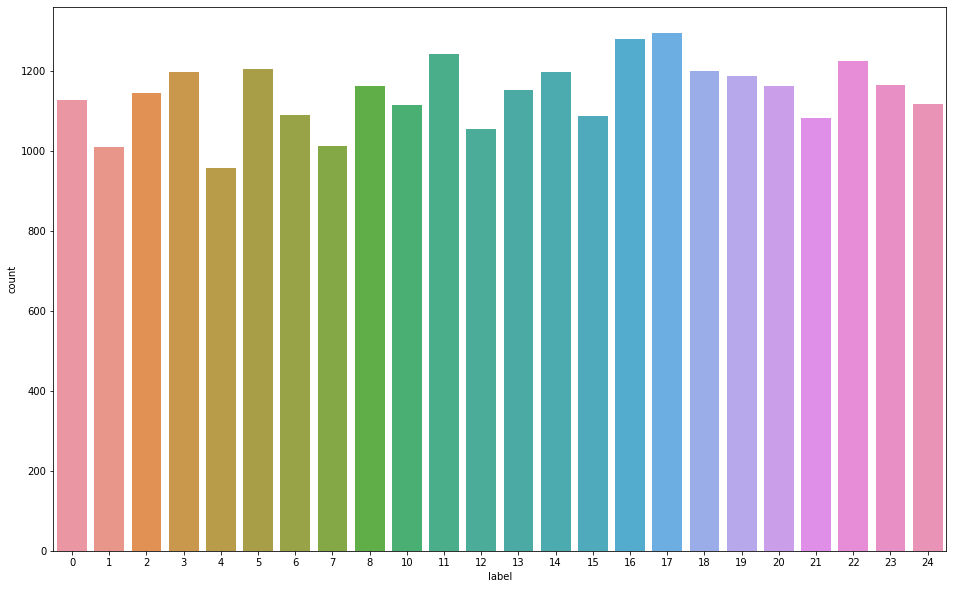

In [ ]:
plt.figure(figsize=(16, 10))
sns.countplot(train_df['label'])
plt.show()

# 전처리

## 입력과 출력 나누기

- x 데이터를 (28, 28, 1) 크기의 이미지 형태로 변환합니다!

In [ ]:
train_df = train_df.astype(np.float32)
x_train = train_df.drop(columns=['label'], axis=1).values
x_train = x_train.reshape((-1, 28, 28, 1))
y_train = train_df[['label']].values

test_df = test_df.astype(np.float32)
x_test = test_df.drop(columns=['label'], axis=1).values
x_test = x_test.reshape((-1, 28, 28, 1))
y_test = test_df[['label']].values

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(27455, 28, 28, 1) (27455, 1)
(7172, 28, 28, 1) (7172, 1)


## 데이터 미리보기

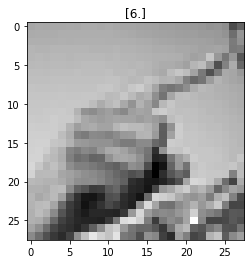

In [ ]:
index = 1
plt.title(str(y_train[index]))
plt.imshow(x_train[index].reshape((28, 28)), cmap='gray')
plt.show()

## One-hot encoding

In [ ]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()
y_test = encoder.fit_transform(y_test).toarray()

print(y_train.shape)

(27455, 24)


## 일반화

이미지 데이터는 픽셀이 0-255 사이의 정수(unsigned integer 8bit = uint8)로 되어 있습니다. 이것을 255로 나누어 0-1 사이의 소수점 데이터(floating point 32bit = float32)로 바꾸고 일반화 시키도록 할게요!

이번에는 ImageDataGenerator()를 사용해서 일반화 시켜보겠습니다!

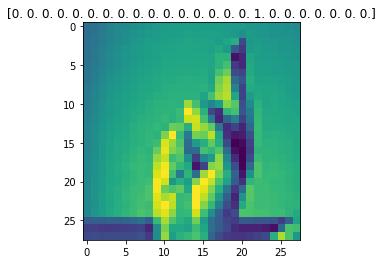

In [ ]:
train_image_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
)

train_datagen = train_image_datagen.flow(
    x=x_train,
    y=y_train,
    batch_size=256,
    shuffle=True
)

test_image_datagen = ImageDataGenerator(
  rescale=1./255
)

test_datagen = test_image_datagen.flow(
    x=x_test,
    y=y_test,
    batch_size=256,
    shuffle=False
)

index = 1

preview_img = train_datagen.__getitem__(0)[0][index]
preview_label = train_datagen.__getitem__(0)[1][index]

plt.imshow(preview_img.reshape((28, 28)))
plt.title(str(preview_label))
plt.show()

# 네트워크 구성

In [ ]:
input = Input(shape=(28, 28, 1))

hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Flatten()(hidden)

hidden = Dense(512, activation='relu')(hidden)

hidden = Dropout(rate=0.3)(hidden)

output = Dense(24, activation='softmax')(hidden)

model = Model(inputs=input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0     

# 학습

In [ ]:
history = model.fit(
    train_datagen,
    validation_data=test_datagen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20 # epochs 복수형으로 쓰기!
)

Epoch 1/20
108/108 [==============================] - 9s 15ms/step - loss: 2.7515 - acc: 0.1880 - val_loss: 0.9185 - val_acc: 0.6941
Epoch 2/20
108/108 [==============================] - 1s 13ms/step - loss: 0.6173 - acc: 0.7950 - val_loss: 0.4233 - val_acc: 0.8557
Epoch 3/20
108/108 [==============================] - 1s 11ms/step - loss: 0.2092 - acc: 0.9337 - val_loss: 0.3073 - val_acc: 0.9071
Epoch 4/20
108/108 [==============================] - 1s 11ms/step - loss: 0.0776 - acc: 0.9782 - val_loss: 0.2549 - val_acc: 0.9338
Epoch 5/20
108/108 [==============================] - 1s 11ms/step - loss: 0.0471 - acc: 0.9886 - val_loss: 0.2658 - val_acc: 0.9375
Epoch 6/20
108/108 [==============================] - 1s 11ms/step - loss: 0.0209 - acc: 0.9960 - val_loss: 0.2707 - val_acc: 0.9334
Epoch 7/20
108/108 [==============================] - 1s 11ms/step - loss: 0.0151 - acc: 0.9968 - val_loss: 0.2820 - val_acc: 0.9346
Epoch 8/20
108/108 [==============================] - 1s 12ms/step - 

# 학습 결과 그래프

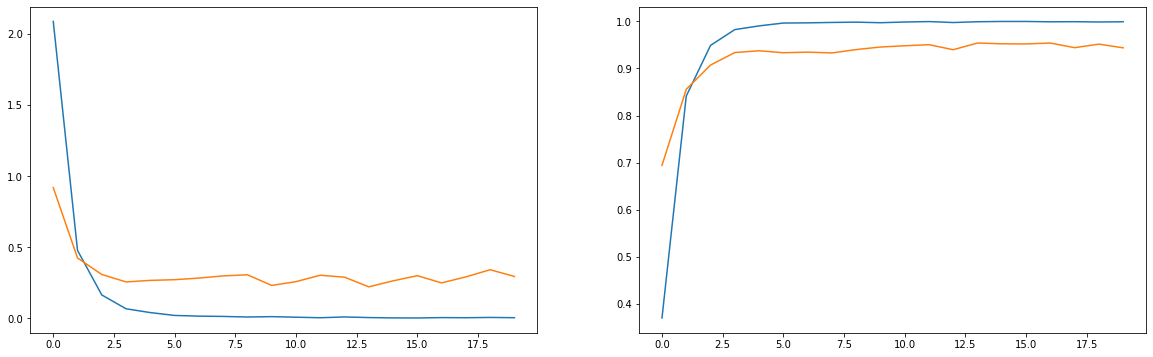

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

# 이미지 증강 기법

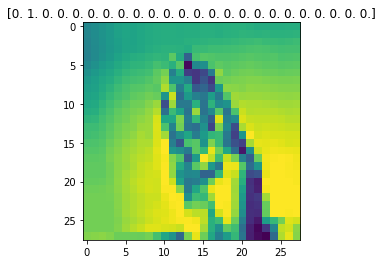

In [ ]:
train_image_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10,  # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
)

train_datagen = train_image_datagen.flow(
    x=x_train,
    y=y_train,
    batch_size=256,
    shuffle=True
)

test_image_datagen = ImageDataGenerator(
  rescale=1./255
)

test_datagen = test_image_datagen.flow(
    x=x_test,
    y=y_test,
    batch_size=256,
    shuffle=False
)

index = 1

preview_img = train_datagen.__getitem__(0)[0][index]
preview_label = train_datagen.__getitem__(0)[1][index]

plt.imshow(preview_img.reshape((28, 28)))
plt.title(str(preview_label))
plt.show()

In [ ]:
input = Input(shape=(28, 28, 1))

hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Flatten()(hidden)

hidden = Dense(512, activation='relu')(hidden)

hidden = Dropout(rate=0.3)(hidden)

output = Dense(24, activation='softmax')(hidden)

model = Model(inputs=input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0   

In [ ]:
history = model.fit(
    train_datagen,
    validation_data=test_datagen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20 # epochs 복수형으로 쓰기!
)

Epoch 1/20
108/108 [==============================] - 7s 64ms/step - loss: 2.9118 - acc: 0.1341 - val_loss: 1.4392 - val_acc: 0.5468
Epoch 2/20
108/108 [==============================] - 7s 67ms/step - loss: 1.4741 - acc: 0.5285 - val_loss: 0.7324 - val_acc: 0.7475
Epoch 3/20
108/108 [==============================] - 7s 65ms/step - loss: 0.8147 - acc: 0.7281 - val_loss: 0.4092 - val_acc: 0.8696
Epoch 4/20
108/108 [==============================] - 7s 64ms/step - loss: 0.5466 - acc: 0.8127 - val_loss: 0.2150 - val_acc: 0.9349
Epoch 5/20
108/108 [==============================] - 7s 63ms/step - loss: 0.3943 - acc: 0.8678 - val_loss: 0.1506 - val_acc: 0.9619
Epoch 6/20
108/108 [==============================] - 7s 63ms/step - loss: 0.2952 - acc: 0.9033 - val_loss: 0.1254 - val_acc: 0.9649
Epoch 7/20
108/108 [==============================] - 7s 63ms/step - loss: 0.2395 - acc: 0.9219 - val_loss: 0.0867 - val_acc: 0.9795
Epoch 8/20
108/108 [==============================] - 7s 63ms/step - 

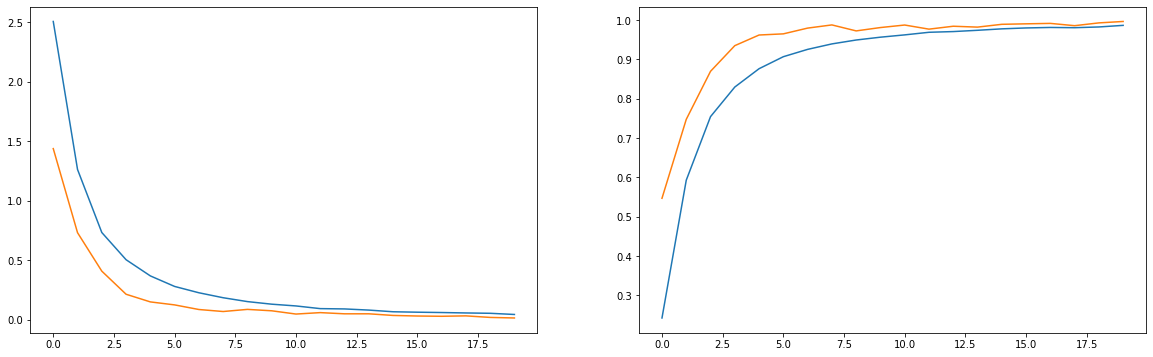

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])